## Data Dictionary: NDBC Standard Meteorological Data (Station 41025)

The dataset consists of hourly meteorological and wave observations collected by the
National Data Buoy Center (NDBC) at Diamond Shoals, North Carolina.

### Time Variables

- **YY**  
  Year of observation (e.g., 2014, 2015)

- **MM**  
  Month of observation (1–12)

- **DD**  
  Day of the month (1–31)

- **hh**  
  Hour of observation (0–23, UTC)

- **mm**  
  Minute of observation (typically 00 or 50 for NDBC hourly data)



### Wind Variables

- **WDIR** (degrees)  
  Wind direction measured clockwise from true north (0–360°)

- **WSPD** (m/s)  
  Wind speed measured at the buoy anemometer height

- **GST** (m/s)  
  Wind gust speed (maximum instantaneous wind speed)


### Wave Variables

- **WVHT** (m)  
  Significant wave height, defined as the average height of the highest one-third of waves  
  This is the primary variable used to estimate wave energy

- **DPD** (s)  
  Dominant wave period, corresponding to the wave component with the most energy

- **APD** (s)  
  Average wave period, computed as the mean of all wave periods  
  Used alongside wave height to calculate wave energy flux

- **MWD** (degrees)  
  Mean wave direction measured clockwise from true north


### Atmospheric Variables

- **PRES** (hPa)  
  Sea-level atmospheric pressure

- **ATMP** (°C)  
  Air temperature measured above the sea surface

- **WTMP** (°C)  
  Sea surface water temperature measured below the water line

- **DEWP** (°C)  
  Dew point temperature, indicating atmospheric moisture content


### Additional Variables

- **VIS** (nautical miles)  
  Horizontal visibility at the buoy location  
y

- **TIDE** (m)  
  Tide height relative to mean sea level  



In [34]:
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor

In [2]:
files = glob.glob("41025h*.txt")

files


['41025h2014.txt',
 '41025h2015.txt',
 '41025h2016.txt',
 '41025h2017.txt',
 '41025h2018.txt',
 '41025h2019.txt']

In [5]:
na_vals = [99, 999, 9999, 99999]

def read_ndbc_stdmet(path):
    # 1) Read the header line that starts with #YY
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        header = None
        for line in f:
            if line.startswith("#YY"):
                header = line.lstrip("#").strip().split()
                break
    if header is None:
        raise ValueError(f"Couldn't find #YY header in {path}")

    # 2) Read the data, skipping comment lines, and apply the header we extracted
    df = pd.read_csv(
        path,
        sep=r"\s+",
        comment="#",
        header=None,
        names=header,
        na_values=na_vals,
        engine="python",
    )
    return df

files = sorted(glob.glob("41025h*.txt"))  # adjust if your files end with .txt

dfs = [read_ndbc_stdmet(f) for f in files]
wave_data = pd.concat(dfs, ignore_index=True)

print(wave_data.shape)
print(wave_data.columns.tolist())
wave_data.head()


(117882, 18)
['YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD', 'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE']


,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2013,12,31,23,50,305.0,7.0,10.0,0.96,5.56,4.41,2.0,1025.5,11.8,23.3,1.8,NaN,NaN
1,2014,1,1,0,50,301.0,6.8,9.5,0.96,6.25,4.40,360.0,1026.6,11.8,23.3,1.4,NaN,NaN
2,2014,1,1,1,50,305.0,7.5,9.5,0.89,5.88,4.23,2.0,1027.6,11.9,23.3,0.5,NaN,NaN
3,2014,1,1,2,50,308.0,6.6,9.4,0.89,5.88,4.15,3.0,1027.9,11.7,23.3,-0.1,NaN,NaN
4,2014,1,1,3,50,322.0,7.0,10.1,0.92,6.25,4.38,26.0,1027.9,12.0,23.2,-0.3,NaN,NaN


In [7]:
wave_data["datetime"] = pd.to_datetime(
    wave_data.rename(columns={"YY":"year","MM":"month","DD":"day","hh":"hour","mm":"minute"})[
        ["year","month","day","hour","minute"]
    ],
    errors="coerce"
)

wave_data = wave_data.dropna(subset=["datetime"]).set_index("datetime").sort_index()


In [8]:
wave_data

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
datetime,,,,,,,,,,,,,,,,,,
2013-12-31 23:50:00,2013,12,31,23,50,305.0,7.0,10.0,0.96,5.56,4.41,2.0,1025.5,11.8,23.3,1.8,NaN,NaN
2014-01-01 00:50:00,2014,1,1,0,50,301.0,6.8,9.5,0.96,6.25,4.40,360.0,1026.6,11.8,23.3,1.4,NaN,NaN
2014-01-01 01:50:00,2014,1,1,1,50,305.0,7.5,9.5,0.89,5.88,4.23,2.0,1027.6,11.9,23.3,0.5,NaN,NaN
2014-01-01 02:50:00,2014,1,1,2,50,308.0,6.6,9.4,0.89,5.88,4.15,3.0,1027.9,11.7,23.3,-0.1,NaN,NaN
2014-01-01 03:50:00,2014,1,1,3,50,322.0,7.0,10.1,0.92,6.25,4.38,26.0,1027.9,12.0,23.2,-0.3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:10:00,2019,12,31,23,10,266.0,8.3,10.7,NaN,NaN,NaN,NaN,1008.9,15.5,23.1,7.0,NaN,NaN
2019-12-31 23:20:00,2019,12,31,23,20,263.0,8.9,11.2,NaN,NaN,NaN,NaN,1009.0,15.5,23.1,7.0,NaN,NaN
2019-12-31 23:30:00,2019,12,31,23,30,271.0,8.6,11.5,NaN,NaN,NaN,NaN,1009.2,15.7,22.9,7.6,NaN,NaN


## Basic Exploration

In [18]:
wave_data.shape

(117882, 18)

In [19]:
wave_data.columns

Index(['YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD', 'GST', 'WVHT', 'DPD',
       'APD', 'MWD', 'PRES', 'ATMP', 'WTMP', 'DEWP', 'VIS', 'TIDE'],
      dtype='object')

In [20]:
wave_data.describe()

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
count,117882.000000,117882.000000,117882.000000,117882.000000,117882.000000,113377.000000,116796.000000,116793.000000,44275.000000,44275.000000,44275.000000,43921.000000,117670.000000,109840.000000,112610.000000,100342.000000,0.0,0.0
mean,2017.570596,7.430643,15.676549,11.485664,31.321661,181.652716,7.474747,9.522094,1.513836,8.138910,5.512834,122.975911,1018.059157,20.912677,24.455103,16.517001,NaN,NaN
std,1.403765,3.303185,8.817413,6.930101,18.330967,111.032522,3.529789,4.337839,0.766391,2.375341,1.071700,70.871369,6.424478,6.737325,3.705266,7.725419,NaN,NaN
min,2013.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.290000,2.740000,3.280000,0.000000,959.200000,-4.500000,5.200000,-11.600000,NaN,NaN
25%,2017.000000,5.000000,8.000000,5.000000,20.000000,72.000000,4.900000,6.300000,0.990000,6.250000,4.750000,66.000000,1014.300000,16.500000,22.400000,11.000000,NaN,NaN
50%,2018.000000,8.000000,16.000000,11.000000,40.000000,208.000000,7.300000,9.200000,1.330000,8.330000,5.340000,111.000000,1018.100000,22.900000,24.600000,18.700000,NaN,NaN
75%,2019.000000,10.000000,23.000000,18.000000,50.000000,262.000000,9.800000,12.300000,1.840000,9.090000,6.080000,180.000000,1021.900000,26.400000,27.500000,23.100000,NaN,NaN
max,2019.000000,12.000000,31.000000,23.000000,50.000000,360.000000,29.700000,39.100000,8.970000,19.050000,11.930000,360.000000,1041.200000,30.600000,32.600000,28.000000,NaN,NaN


In [21]:
wave_data.isna().sum().sort_values(ascending=False)

TIDE    117882
VIS     117882
MWD      73961
WVHT     73607
APD      73607
DPD      73607
DEWP     17540
ATMP      8042
WTMP      5272
WDIR      4505
GST       1089
WSPD      1086
PRES       212
MM           0
mm           0
hh           0
DD           0
YY           0
dtype: int64

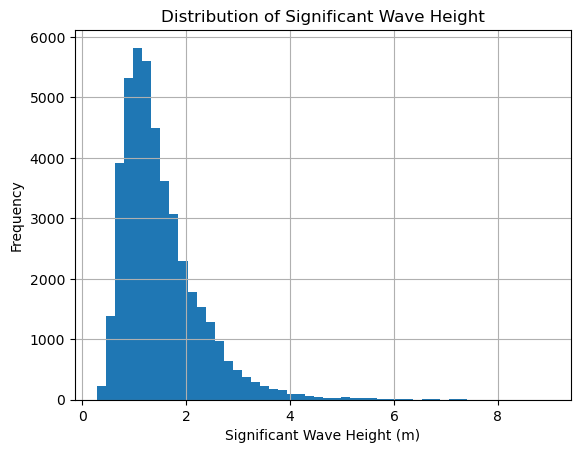

In [24]:
wave_data["WVHT"].hist(bins=50)
plt.xlabel("Significant Wave Height (m)")
plt.ylabel("Frequency")
plt.title("Distribution of Significant Wave Height")
plt.show()

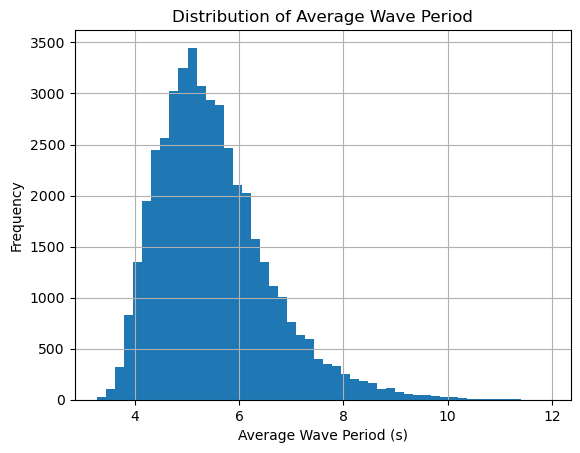

In [25]:
wave_data["APD"].hist(bins=50)
plt.xlabel("Average Wave Period (s)")
plt.ylabel("Frequency")
plt.title("Distribution of Average Wave Period")
plt.show()

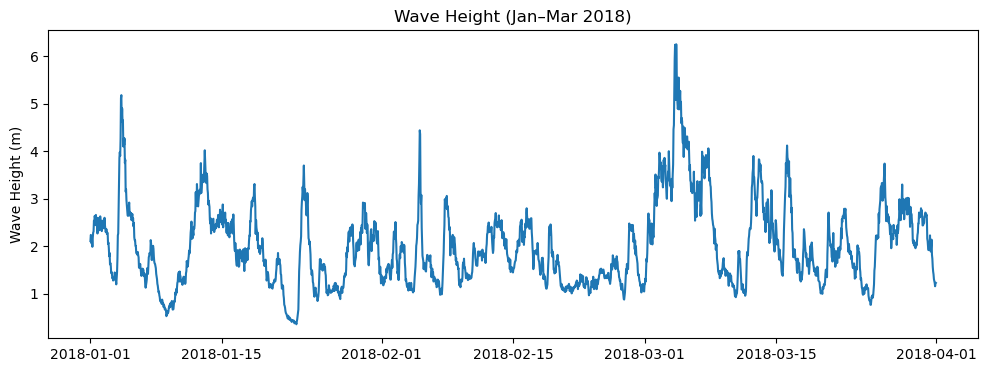

In [31]:
sample = wave_data.loc["2018-01-01":"2018-03-31", "WVHT"].dropna()

plt.figure(figsize=(12,4))
plt.plot(sample.index, sample)
plt.ylabel("Wave Height (m)")
plt.title("Wave Height (Jan–Mar 2018)")
plt.show()


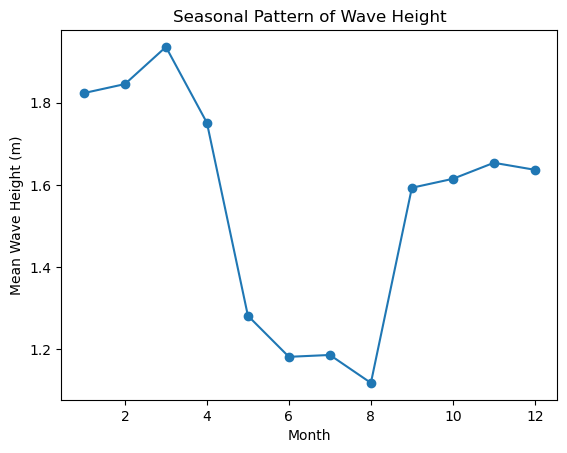

In [27]:
monthly_wvht = wave_data["WVHT"].groupby(wave_data.index.month).mean()

monthly_wvht.plot(marker="o")
plt.xlabel("Month")
plt.ylabel("Mean Wave Height (m)")
plt.title("Seasonal Pattern of Wave Height")
plt.show()


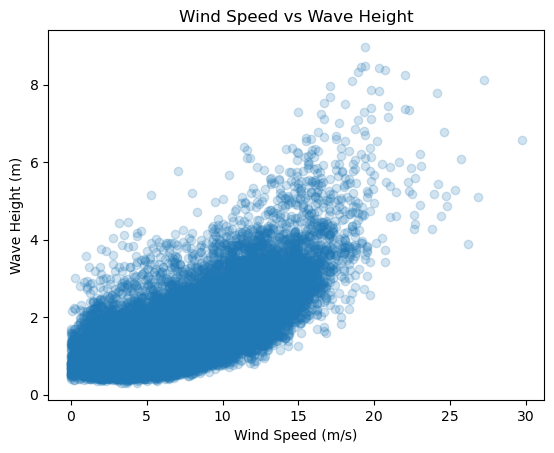

In [28]:
plt.scatter(
    wave_data["WSPD"],
    wave_data["WVHT"],
    alpha=0.2
)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")
plt.title("Wind Speed vs Wave Height")
plt.show()


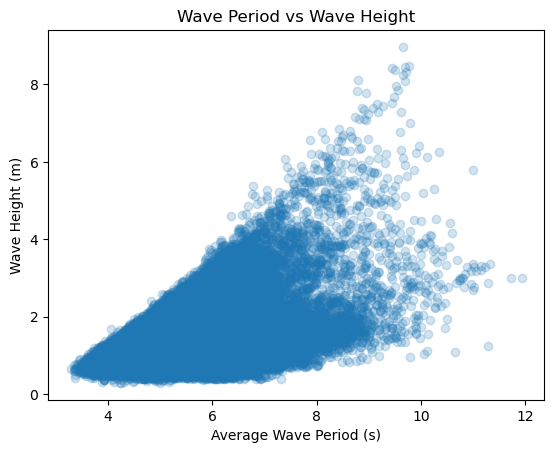

In [29]:
plt.scatter(
    wave_data["APD"],
    wave_data["WVHT"],
    alpha=0.2
)
plt.xlabel("Average Wave Period (s)")
plt.ylabel("Wave Height (m)")
plt.title("Wave Period vs Wave Height")
plt.show()


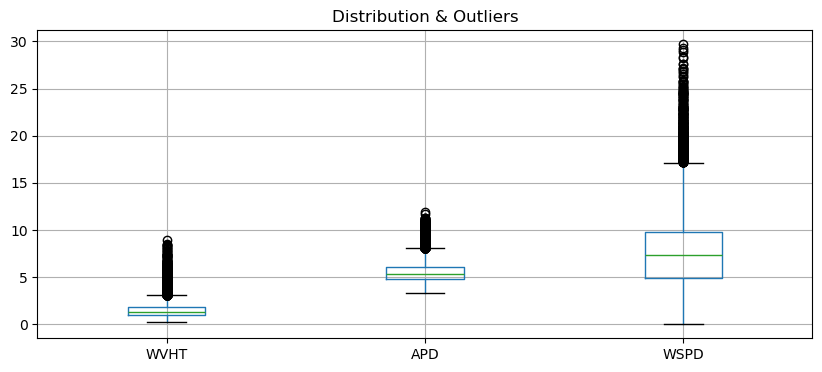

In [30]:
plt.figure(figsize=(10,4))
wave_data[["WVHT", "APD", "WSPD"]].boxplot()
plt.title("Distribution & Outliers")
plt.show()

In [14]:
corr_vars = [
    "WDIR", "WSPD", "GST",
    "DPD", "APD", "MWD",
    "PRES", "ATMP", "WTMP",
    "DEWP", "WVHT"
]

corr_data = wave_data[corr_vars].copy()


In [15]:
corr_matrix = corr_data.corr()

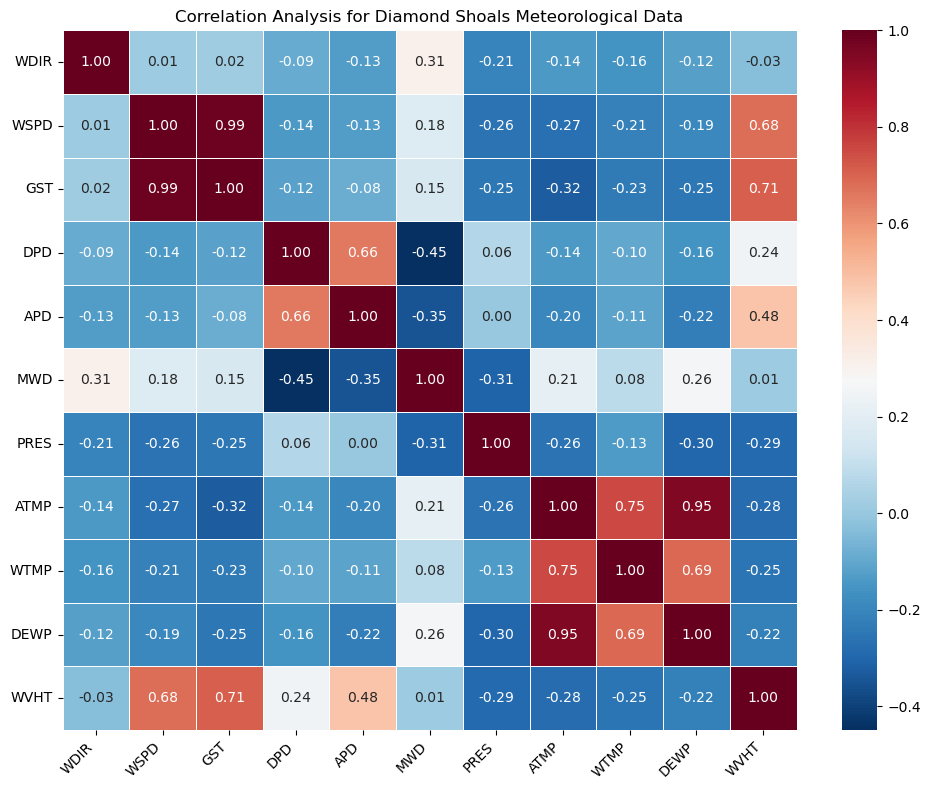

In [17]:
plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    cmap="RdBu_r",       
    annot=True,       
    fmt=".2f",
    linewidths=0.5,
    cbar=True
)

plt.title("Correlation Analysis for Diamond Shoals Meteorological Data", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## MODEL BUILDING

# WAVE HEIGHT 

Based on the correlation matrix above these are the features selected.

In [32]:
wvht_features = [
    "WSPD",   # wind forcing
    "GST",    # extreme wind forcing
    "APD",    # wave temporal structure
    "PRES",   # atmospheric forcing
    "ATMP"    # air–sea interaction
]


In [33]:
apd_features = [
    "DPD",    # dominant wave structure
    "WSPD",   # wind forcing
    "PRES",   # atmospheric conditions
    "ATMP"    # thermal influence
]


In [44]:
target = "WVHT"
features = ["WSPD", "GST", "APD", "PRES", "ATMP"]

df = wave_data[features + [target]].copy()
df = df.dropna()



In [45]:
train_df = df.loc["2014-01-01":"2018-12-31"]
test_df  = df.loc["2019-01-01":"2019-12-31"]

X_train = train_df[features].values
y_train = train_df[target].values

X_test  = test_df[features].values
y_test  = test_df[target].values


In [46]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)

y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_s  = scaler_y.transform(y_test.reshape(-1,1)).ravel()


In [47]:
models = {
    "LR": LinearRegression(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "DT": DecisionTreeRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

stack = StackingRegressor(
    estimators=[
        ("dt", models["DT"]),
        ("xgb", models["XGBoost"])
    ],
    final_estimator=LinearRegression(),
    passthrough=False
)

models["XGBDT"] = stack


In [48]:
results = []
preds_df = pd.DataFrame(index=test_df.index)
preds_df["Actual_WVHT"] = y_test

for name, model in models.items():
    model.fit(X_train_s, y_train_s)
    
    y_pred_s = model.predict(X_test_s)
    
    # inverse-scale predictions 
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "RMSE (m)": rmse,
        "R2": r2
    })
    
    preds_df[f"Pred_{name}"] = y_pred


In [49]:
results_df = pd.DataFrame(results).sort_values("RMSE (m)")
results_df


,Model,RMSE (m),R2
4,XGBDT,0.270118,0.907272
3,XGBoost,0.271186,0.906537
1,KNN,0.345233,0.848529
0,LR,0.380329,0.816166
2,DT,0.401539,0.795091


In [50]:
preds_df.to_excel("WVHT_predictions.xlsx")


In [51]:
plot_df = preds_df.iloc[:100].copy()

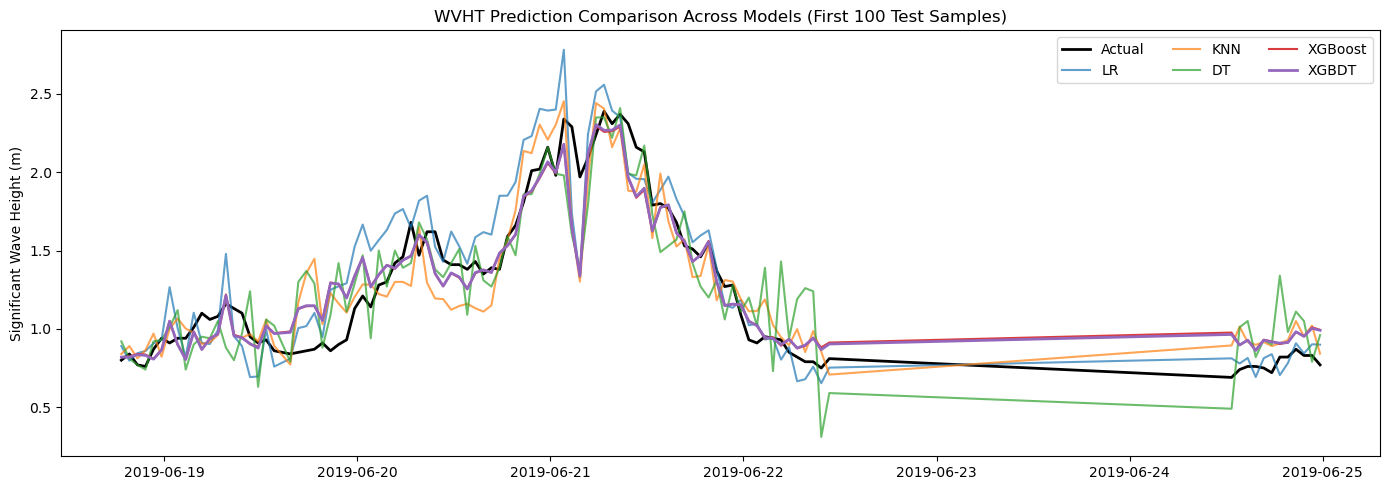

In [54]:
plt.figure(figsize=(14,5))

plt.plot(plot_df.index, plot_df["Actual_WVHT"], label="Actual", color="black", linewidth=2)

plt.plot(plot_df.index, plot_df["Pred_LR"], label="LR", alpha=0.7)
plt.plot(plot_df.index, plot_df["Pred_KNN"], label="KNN", alpha=0.7)
plt.plot(plot_df.index, plot_df["Pred_DT"], label="DT", alpha=0.7)
plt.plot(plot_df.index, plot_df["Pred_XGBoost"], label="XGBoost", alpha=0.9)
plt.plot(plot_df.index, plot_df["Pred_XGBDT"], label="XGBDT", linewidth=2)

plt.ylabel("Significant Wave Height (m)")
plt.title("WVHT Prediction Comparison Across Models (First 100 Test Samples)")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()


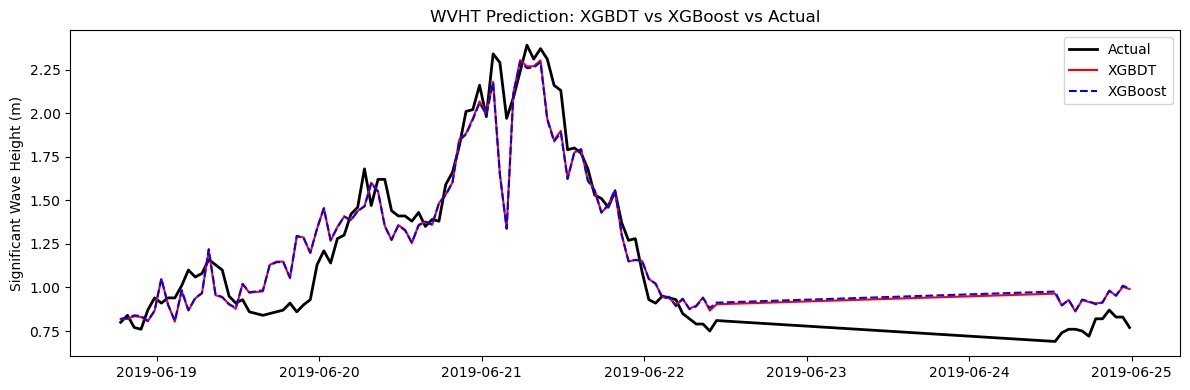

In [53]:
plt.figure(figsize=(12,4))

plt.plot(plot_df.index, plot_df["Actual_WVHT"], label="Actual", color="black", linewidth=2)
plt.plot(plot_df.index, plot_df["Pred_XGBDT"], label="XGBDT", color="red")
plt.plot(plot_df.index, plot_df["Pred_XGBoost"], label="XGBoost", color="blue", linestyle="--")

plt.ylabel("Significant Wave Height (m)")
plt.title("WVHT Prediction: XGBDT vs XGBoost vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


# Average Wave Period